In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

Loading CSV files into pandas format and merging them together to create a training set similar to the test set:

In [25]:
df1 = pd.read_csv('dc_signal_strength.csv')
df2 = pd.read_csv('dc_ipads.csv')
df3 = pd.read_csv('dc_ap_locations.csv')

Since for iPad ID - '0452f3640b3e' there is no Access Point information, I removed it from the training set.

In [26]:
merge1 = pd.merge(df1, df2, how='inner', on='iPad ID')
merge2 = pd.merge(merge1, df3, how='inner', on='Access Point ID')
merge2.head()

,iPad ID,Access Point ID,Signal Strength,iPad Name,iPad x,iPad y,Floor,Access Point x,Access Point y
0,0452f3638d1a,b45d50f656d0,43,Big Sur,3.0,49.2,3,2.725522,43.234657
1,0452f3638d1a,b45d50f656d0,43,Big Sur,3.0,49.2,3,2.725522,43.234657
2,0452f3638d1a,b45d50f656d0,43,Big Sur,3.0,49.2,3,2.725522,43.234657
3,0452f3638d1a,b45d50f656d0,43,Big Sur,3.0,49.2,3,2.725522,43.234657
4,0452f3638d1a,b45d50f656d0,43,Big Sur,3.0,49.2,3,2.725522,43.234657


In [27]:
merge2['log_db'] = merge2['Signal Strength'].apply(lambda x : np.log(x))
merge2['x2'] = merge2['Access Point x'].apply(lambda x : x*x)
merge2['y2'] = merge2['Access Point y'].apply(lambda x : x*x)

Preparing merge2 for fitting ML models

In [28]:
X = merge2[['Signal Strength', 'Access Point x', 'Access Point y', 'log_db', 'x2', 'y2']]
y1 = merge2[['iPad x']]
y2 = merge2[['iPad y']]

In [29]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

<AxesSubplot:xlabel='Access Point x', ylabel='iPad x'>

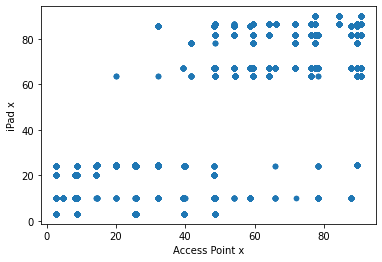

In [6]:
merge2.plot.scatter('Access Point x', 'iPad x')

<AxesSubplot:xlabel='Access Point y', ylabel='iPad y'>

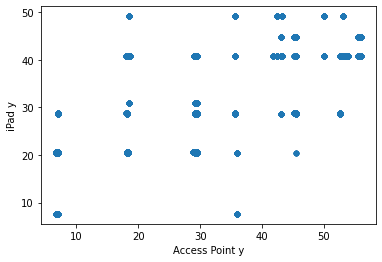

In [7]:
merge2.plot.scatter('Access Point y', 'iPad y')

<AxesSubplot:xlabel='Signal Strength', ylabel='iPad x'>

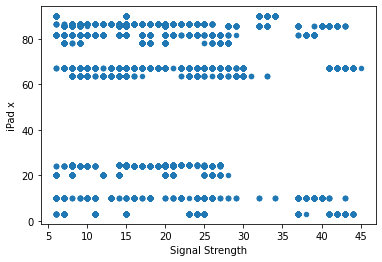

In [8]:
merge2.plot.scatter('Signal Strength', 'iPad x')

<AxesSubplot:xlabel='Signal Strength', ylabel='iPad y'>

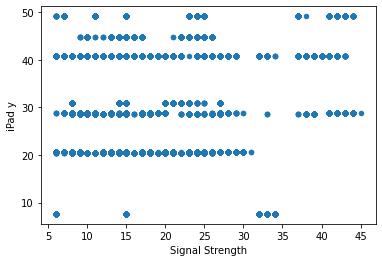

In [9]:
merge2.plot.scatter('Signal Strength', 'iPad y')

Since from the above plots we can see that there is no linear relation between the dependent and independent variables, we can assume that Linear Regression will not be able to fit the data well.

In [30]:
lr = LinearRegression()
lr.fit(X_train, y1_train)
y1_pred_lr = lr.predict(X_test)

lr.fit(X_train, y2_train)
y2_pred_lr = lr.predict(X_test)

print('Mean Squared error for iPad x:', mean_squared_error(y1_test, y1_pred_lr))
print('Mean Squared error for iPad y:', mean_squared_error(y2_test, y2_pred_lr))

Mean Squared error for iPad x: 349.87651927476264
Mean Squared error for iPad y: 37.42439414173982


As expected, the mean squared error for linear regression is very high. We will try fitting a Decision Tree Regressor to the data instead.

In [31]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y1_train)
y1_pred_dt = dt_reg.predict(X_test)

feature_importances_ipadx = dt_reg.feature_importances_

dt_reg.fit(X_train, y2_train)
y2_pred_dt = dt_reg.predict(X_test)

feature_importances_ipady = dt_reg.feature_importances_

print('Mean Squared error for iPad x:', mean_squared_error(y1_test, y1_pred_dt))
print('Mean Squared error for iPad y:', mean_squared_error(y2_test, y2_pred_dt))

Mean Squared error for iPad x: 22.73595419064039
Mean Squared error for iPad y: 1.9740448979148049


In [12]:
print('Feature Importances for estimating ipad x: ', feature_importances_ipadx)
print('Feature Importances for estimating ipad y: ', feature_importances_ipady)

Feature Importances for estimating ipad x:  [0.1748093  0.75281995 0.07237076]
Feature Importances for estimating ipad y:  [0.17918934 0.22422677 0.59658389]


While predicting iPad x, the feature Access Point x has more importance.
Whereas while predicting iPad y, the feature Access Point y has more importance. 

We can see that there is a huge improvement in mean squared error from linear regression to decision tree.

Visualizing the Decision Tree: 

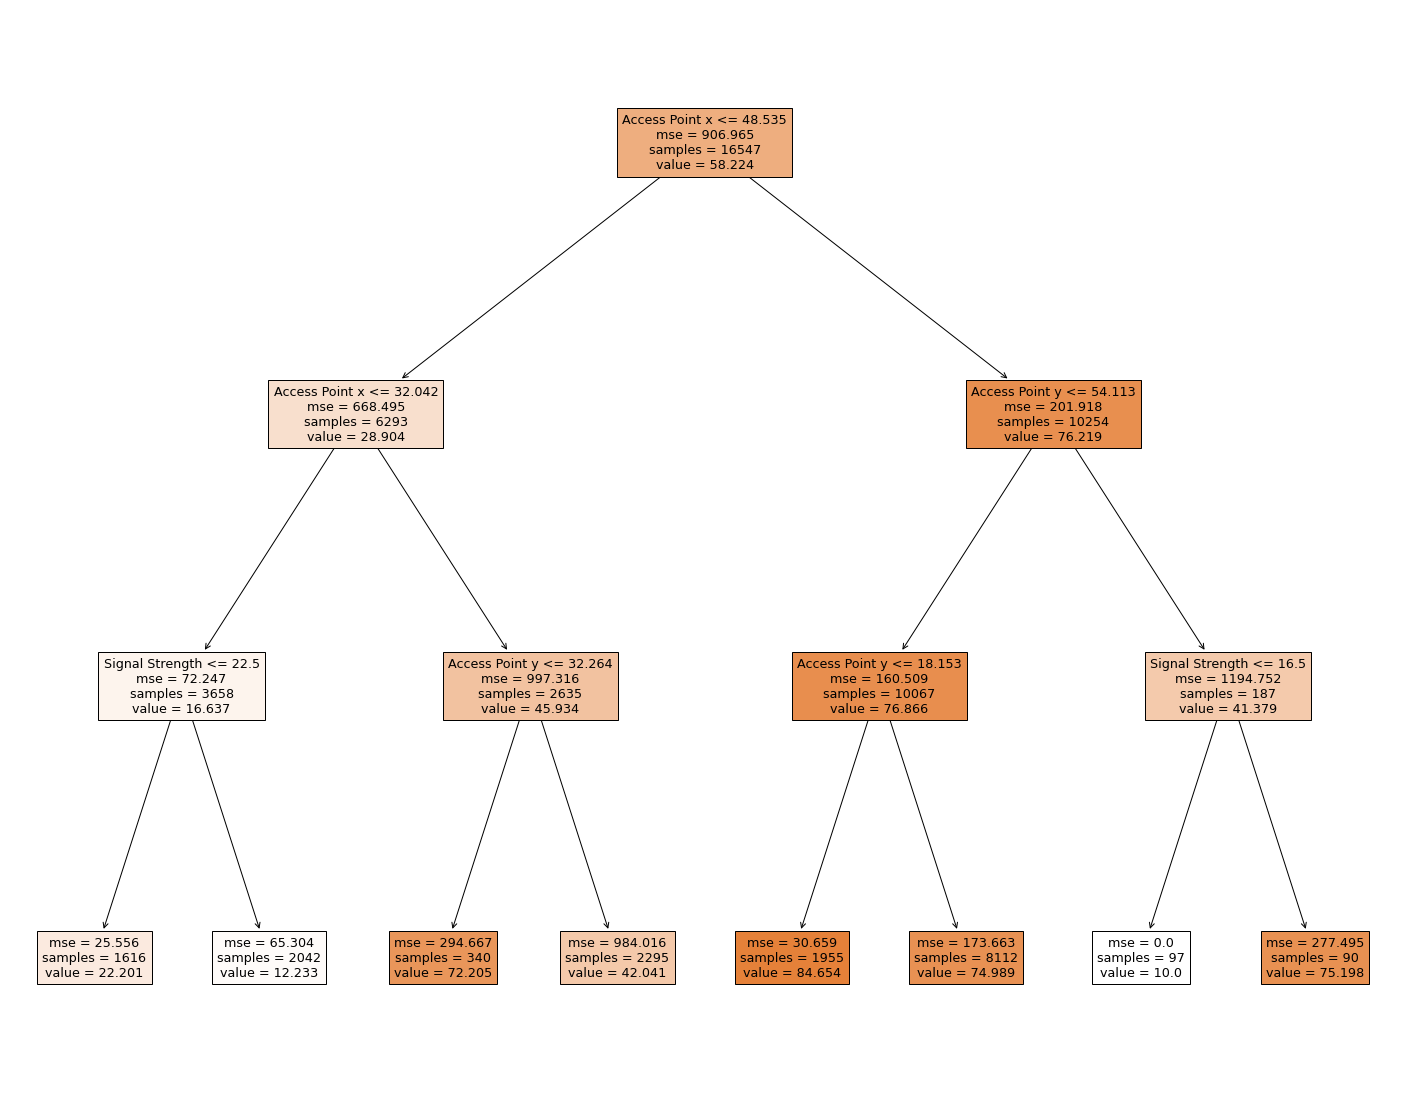

In [13]:
from sklearn import tree

dt_reg = DecisionTreeRegressor(max_depth=3)
dt_reg.fit(X_train, y1_train)

text_representation = tree.export_text(dt_reg)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_reg, 
                   feature_names=X_train.columns,  
                   filled=True)

<AxesSubplot:xlabel='Access Point x', ylabel='iPad x'>

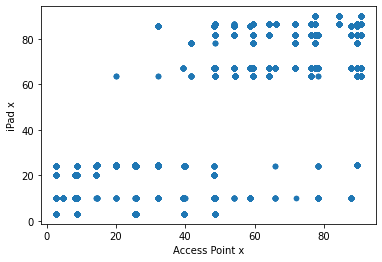

In [14]:
merge2.plot.scatter('Access Point x', 'iPad x')

The decision tree is first splitting based on Access point x by thresholding on ~48 which is very intuitive from the above plot.

Creating Final Prediction Data using a decision tree.

In [15]:
df = pd.read_csv('dc_test_data.csv')
test_df = df[['Signal Strength', 'Access Point x', 'Access Point y']]

In [16]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y1_train)
y1_pred_final = dt_reg.predict(test_df)

dt_reg.fit(X_train, y2_train)
y2_pred_final = dt_reg.predict(test_df)

In [17]:
final_df = pd.DataFrame()
final_df['iPad ID'] = df['iPad ID']
final_df['iPad x'] = y1_pred_final
final_df['iPad y'] = y2_pred_final
final_df.head()

,iPad ID,iPad x,iPad y
0,0452f360ef9f,24.0,40.8
1,0452f360ef9f,10.0,40.8
2,0452f360ef9f,67.2,44.8
3,0452f36c3d9d,86.4,20.5
4,0452f36c3d9d,81.6,28.7


In [18]:
final_df.to_csv('FinalSubmission.csv', index=None)

I also tried Gradient Boosting, which is an ensemble method but did not see much improvement. This could be because the data is quite simple and more improvement couldn't be made after just once decision tree.

In [19]:
gb_reg = GradientBoostingRegressor(n_estimators=1000, max_depth=25)
gb_reg.fit(X_train, y1_train)
y1_pred_gb = gb_reg.predict(X_test)

gb_reg.fit(X_train, y2_train)
y2_pred_gb = gb_reg.predict(X_test)

print('Mean Squared error for iPad x:', mean_squared_error(y1_test, y1_pred_gb))
print('Mean Squared error for iPad y:', mean_squared_error(y2_test, y2_pred_gb))

/Users/kalyaniasthana/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/kalyaniasthana/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Mean Squared error for iPad x: 22.698098897684805
Mean Squared error for iPad y: 1.9577915742143301
